# 문서 유사도 (Document Similarity)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os, glob

path = 'C:\\encore_sk-net-fam_9\\lecture_source\\nlp\\01_text_analysis\\data\\OpinosisDataset1.0\\topics'
all_files = glob.glob(os.path.join(path, '*.data'))

filename_list = []
opinions_list = []

for file_ in all_files:
    df = pd.read_table(file_, header=None, index_col=None, encoding='latin1')
    # display(df)

    # 파일명
    filename = file_.split('\\')[-1]
    filename = filename.split('.')[0]
    filename_list.append(filename)

    # 의견 내용
    opinions = df.to_string(index=False, header=False)
    opinions_list.append(opinions)

document_df = pd.DataFrame({
    'filename': filename_list,
    'opinions': opinions_list
})

document_df

,filename,opinions
0,accuracy_garmin_nuvi_255W_gps,...
1,bathroom_bestwestern_hotel_sfo,...
2,battery-life_amazon_kindle,...
3,battery-life_ipod_nano_8gb,...
4,battery-life_netbook_1005ha,...
5,buttons_amazon_kindle,...
6,comfort_honda_accord_2008,...
7,comfort_toyota_camry_2007,...
8,directions_garmin_nuvi_255W_gps,...
9,display_garmin_nuvi_255W_gps,...


In [3]:
import string
import nltk
from nltk.stem import WordNetLemmatizer

def lemmatize(text):
    # 소문자 변환
    text = text.lower()

    # 특수문자 변환 (제거)
    punc_rem_dict = dict((ord(ch), None) for ch in string.punctuation)
    text = text.translate(punc_rem_dict)

    # 토큰화
    tokens = nltk.word_tokenize(text)

    # 어근 분리
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token, pos='v') for token in tokens]

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    tokenizer=lemmatize,
    stop_words='english',
    ngram_range=(1, 2),
    max_df=0.85,
    min_df=0.05
)
opinions_vecs = tfidf_vectorizer.fit_transform(document_df['opinions'])

c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\USER\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  warnings.warn(


In [5]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, max_iter=5000, random_state=0)
document_df['cluster'] = kmeans.fit_predict(opinions_vecs)
document_df

,filename,opinions,cluster
0,accuracy_garmin_nuvi_255W_gps,...,2
1,bathroom_bestwestern_hotel_sfo,...,1
2,battery-life_amazon_kindle,...,0
3,battery-life_ipod_nano_8gb,...,2
4,battery-life_netbook_1005ha,...,2
5,buttons_amazon_kindle,...,0
6,comfort_honda_accord_2008,...,3
7,comfort_toyota_camry_2007,...,3
8,directions_garmin_nuvi_255W_gps,...,2
9,display_garmin_nuvi_255W_gps,...,2


In [7]:
hotel_index = document_df[document_df['cluster'] == 1].index
print(hotel_index.shape)
print(hotel_index)

base_index = 1
document_df.iloc[base_index]

(15,)
Index([1, 13, 14, 15, 20, 21, 24, 30, 31, 32, 38, 39, 40, 45, 46], dtype='int64')


filename                       bathroom_bestwestern_hotel_sfo
opinions                                                  ...
cluster                                                     1
Name: 1, dtype: object

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

# print(opinions_vecs[base_index].shape, opinions_vecs.shape)
opinions_sim = cosine_similarity(opinions_vecs[base_index], opinions_vecs)
opinions_sim

array([[0.00748211, 1.        , 0.00929825, 0.0057907 , 0.00951122,
        0.01189862, 0.04207734, 0.05068772, 0.00883856, 0.00840561,
        0.01333684, 0.0118808 , 0.01204711, 0.04527121, 0.05728026,
        0.06248841, 0.00753869, 0.02152493, 0.01696471, 0.02047214,
        0.06173425, 0.06124276, 0.00748295, 0.00877269, 0.04074639,
        0.01315832, 0.0105536 , 0.0222888 , 0.11626805, 0.00537765,
        0.41683399, 0.36028138, 0.51119681, 0.00799792, 0.01306653,
        0.01888393, 0.02248538, 0.01884263, 0.11499329, 0.15210166,
        0.1506946 , 0.04685638, 0.00708347, 0.00407049, 0.0150326 ,
        0.09851446, 0.08026128, 0.00684375, 0.00568624, 0.00898582,
        0.0080185 ]])

In [11]:
opinion_sorted_idx = opinions_sim.argsort()[:, ::-1] # 내림차순 정렬 (유사도 높은순)
opinion_sorted_idx = opinion_sorted_idx[:, 1:]       # 자기자신 제외
opinion_sorted_idx = opinion_sorted_idx.reshape(-1)  # 1차원으로 변형

result_df = document_df.iloc[opinion_sorted_idx][['filename', 'cluster']]
opinions_sim = opinions_sim.reshape(-1)
result_df['similarity'] = opinions_sim[opinion_sorted_idx]
result_df

,filename,cluster,similarity
32,room_holiday_inn_london,1,0.511197
30,rooms_bestwestern_hotel_sfo,1,0.416834
31,rooms_swissotel_chicago,1,0.360281
39,service_holiday_inn_london,1,0.152102
40,service_swissotel_hotel_chicago,1,0.150695
28,price_holiday_inn_london,0,0.116268
38,service_bestwestern_hotel_sfo,1,0.114993
45,staff_bestwestern_hotel_sfo,1,0.098514
46,staff_swissotel_chicago,1,0.080261
15,free_bestwestern_hotel_sfo,1,0.062488


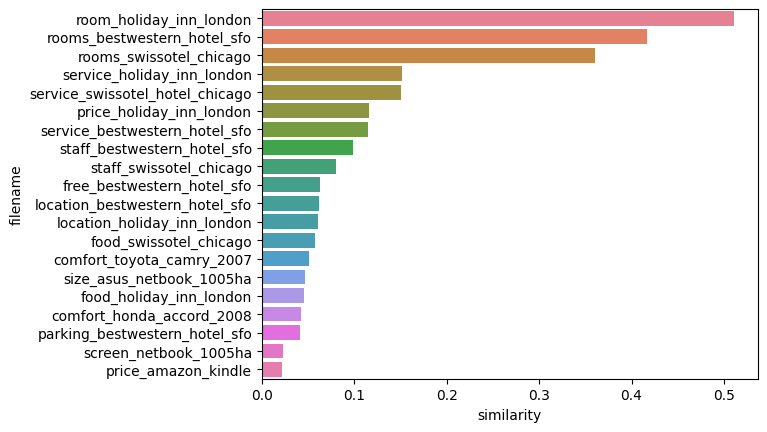

In [12]:
sns.barplot(x='similarity', y='filename', data=result_df.iloc[:20], hue='filename')
plt.show()